In [3]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [4]:
CONFIG_FILE = Path("src/ml/config.yaml")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

In [5]:
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow

model = WeightSharingTreeFlow.load_from_checkpoint("ml_data/models/tuned_weight_sharing_fraction_height_yule_10_2025_01_10_14_00_11/yule-10_5/epoch=21-val_loss=-27.47.ckpt")
model = model.eval()

RuntimeError: Error(s) in loading state_dict for WeightSharingTreeFlow:
	Missing key(s) in state_dict: "taxa_names", "flows.1.scale", "flows.1.running_mean", "flows.9.scaling", "flows.9.mask", "flows.9.translate.layers.0.0.weight", "flows.9.translate.layers.0.0.bias", "flows.9.translate.layers.1.weight", "flows.9.translate.layers.1.bias", "flows.9.scale.layers.0.0.weight", "flows.9.scale.layers.0.0.bias", "flows.9.scale.layers.1.weight", "flows.9.scale.layers.1.bias", "height_model.mean", "height_model.log_scale", "height_model.has_been_initialized". 
	Unexpected key(s) in state_dict: "flows.1.scaling", "flows.1.mask", "flows.1.translate.layers.0.0.weight", "flows.1.translate.layers.0.0.bias", "flows.1.translate.layers.1.weight", "flows.1.translate.layers.1.bias", "flows.1.scale.layers.0.0.weight", "flows.1.scale.layers.0.0.bias", "flows.1.scale.layers.1.weight", "flows.1.scale.layers.1.bias", "height_model.shared.weight", "height_model.shared.bias", "height_model.mean.weight", "height_model.mean.bias", "height_model.log_scale.weight", "height_model.log_scale.bias". 

In [23]:
from src.ml.data.tree_dataset import TreeDataset

map_tree_file = Path("data/map_data/yule-10_140_49247_mrca.trees")
data_set = TreeDataset(map_tree_file)

for preprocessing_step in config["preprocessing"]:
    transform = preprocessing_factory(**preprocessing_step)
    data_set = transform(data_set)

data_loader = DataLoader(data_set, batch_size=1)

mrca_batch = next(iter(data_loader))

In [2]:
# load data

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

NameError: name 'data_sets_factory' is not defined

In [24]:
model.freeze()

In [120]:
from torch import nn

class Module(nn.Module):
    def __init__(self, model, clades, tree_height, **kwargs):
        super().__init__()
        model.freeze()
        
        self.unnormalized_branch_lengths = torch.nn.Parameter(torch.rand(mrca_batch["branch_lengths"].shape), requires_grad=True)
        self.wrapped_model = model
        self.clades = clades
        self.tree_height = tree_height

    def loss(self):
        normalized_branch_lengths = torch.sigmoid(self.unnormalized_branch_lengths)

        batch = {
            "branch_lengths": normalized_branch_lengths,
            "clades": self.clades,
            "tree_height": self.tree_height,
        }

        return -self.wrapped_model.get_log_likelihood(batch)

wrapped_model = Module(model, **mrca_batch)
optim = torch.optim.SGD(wrapped_model.parameters(), lr=1e-1)

losses = []

num_steps = 100
for _ in range(num_steps):
    loss = wrapped_model.loss()
    loss.backward()
    optim.step()
    optim.zero_grad()
    losses.append(float(loss))

<Axes: >

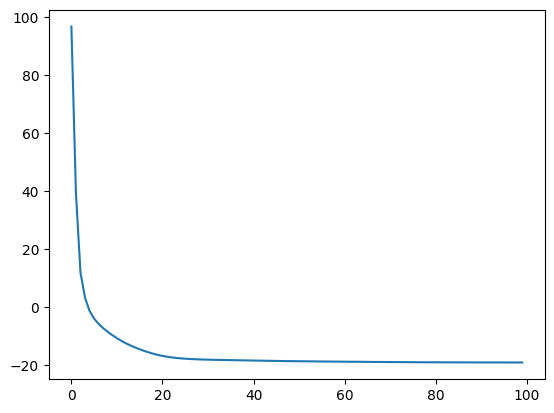

In [121]:
import seaborn as sns

sns.lineplot(losses)

In [137]:
map = torch.sigmoid(wrapped_model.unnormalized_branch_lengths)

In [131]:
mrca = mrca_batch["branch_lengths"]

In [133]:
mrca_batch["branch_lengths"] = mrca
model.get_log_likelihood(mrca_batch)

tensor([-90.1778], grad_fn=<AddBackward0>)

In [138]:
mrca_batch["branch_lengths"] = map.detach()
model.get_log_likelihood(mrca_batch)

tensor([19.0946])

In [135]:
map

tensor([[0.1830, 0.0770, 0.0570, 0.0520, 0.1510, 0.2360, 0.1680, 0.1940, 0.0000]],
       grad_fn=<DivBackward0>)